# An Intro to Time Series Analysis in Python

The goal of this notebook is introduce some key concepts for getting started with time series analysis. After working through this short notebook, you should have a sense of a where to start with analyzing time series data and how you can begin generating insights.

This tutorial leans heavily on content found in [here](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) and [here](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/), both of which can be used as a jumping off point for reading.  While useful, these are much longer tutorials. Our goal here is to provide you with something streamlined to get you started quickly!

**Note:** Please send along any errata or comments you may have.

### Outline
---

1. [**Loading example data**](#data)
2. [**The Concept of Stationarity**](#stationarity-concept)
3. [**Assessing Stationarity**](#stationarity-assessing)
    - [Looking at the data](#eyeballs)
    - [Augmented Dickey-Fuller Test](#adf)
<br>
<br>
4. [**Identifying Trend and Seasonality**](#identifying-trends)
    - [Removing Trend to Make a Time Series Stationary](#trend-removal)
    - [Differencing to Detrend](#differencing)     
    - [Decomposition - Modeling Trend and Season Separately](#decomposition)     
<br>
5. [**Relating Two Separate Time Series**](#two-series)
    - [Granger Causality](#granger)
<br>
<br>
6. [**Take Aways and Next Steps**](#summary)

### Dependencies
---

This notebook uses data from the files "NH_seaice_extent_final_v2.csv" and "Antarctic_Temperatures.csv". In addition, this notebook requires the following libraries:
- numpy
- pandas
- matplotlib
- seaborn
- **statsmodels**


<a id='data'></a>
## Loading Example Data

The data we will work with in this tutorial is real measurements of Antarctic Ice extent. As you can imagine, there is probably a strong seasonal aspect to ice melting and re-freezing, as well as possible long term climate change trends. The original data were on a daily timescale, but we will average within months to simplify things a bit.

You should be able to just run these lines to get your data prepped for the tutorial

In [97]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [98]:
# read data into a pandas dataframe
df = pd.read_csv('NH_seaice_extent_final_v2.csv')

In [99]:
df.columns.tolist()

['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data']

In [100]:
# light munging to deal with file format and dump unnecessary columns
df.columns = [col.strip() for col in df.columns.tolist()]
# drop the first row, which is a descriptor row
df = df.drop(0) 
# drop columns "Missing" and "Source Data"
df = df.drop(['Missing','Source Data'], axis=1)
# convert the rest columns to numeric
df.Extent = pd.to_numeric(df.Extent)
df.Year = pd.to_numeric(df.Year)
df.Month = pd.to_numeric(df.Month)
df.head()
# Year, Month, Day, Extent (in 10^6 square km)

,Year,Month,Day,Extent
1,1978,10,26,10.231
2,1978,10,28,10.420
3,1978,10,30,10.557
4,1978,11,01,10.670
5,1978,11,03,10.777


In [101]:
# calculate the mean of extent based on the year-month group
monthly = df.groupby(['Year', 'Month'])['Extent'].mean()
# "reset_index", move index to column after "groupby"
monthly = monthly.reset_index()
monthly['Day'] = 1

# create a new index using datetime
monthly.index = pd.to_datetime(monthly.loc[:, ['Year', 'Month', 'Day']])

In [102]:
monthly.head()

,Year,Month,Extent,Day
1978-10-01,1978,10,10.402667,1
1978-11-01,1978,11,11.645133,1
1978-12-01,1978,12,13.667063,1
1979-01-01,1979,1,15.414000,1
1979-02-01,1979,2,16.175286,1


<a id='stationarity-concept'></a>
# The Concept of Stationary Data

**Stationary Timeseries data have constant mean and variance over time, as well as constant autocorrelation over time.** 

If you look at the seasonality, the frequency and amplitude should remain somewhat constant over time. Additionally, there shouldn't be a trend for the mean to increase or decrease as time goes on.

![Image of Mean Non-stationary](https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Mean_nonstationary.png)

![Non-stationary due to variance](https://www.analyticsvidhya.com/wp-content/uploads/2015/02/Var_nonstationary.png)

** Real data almost always behave non-stationary.**


Of course, real data doesn't behave like this, it almost always is non-stationary. In this example, we'll look at data describing the extent of antarctic ice measured monthly. You can imagine that this varies both within a year (a season component), as well as across years (a trend).


** Many assumptions applied to independent random variables also apply to stationary time series data. **

A good discussion of the importance of stationary data to time series analysis can be found [here](http://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary). A key take away on the importance of stationarity is that it is a necessary condition for many of the assumptions that underlie statistical tests. 


For almost all time series analyses we are going to want to apply (at least some) statistical tests before we dive into modeling.  Therefore, ***the first thing to do*** when working with time series data is to assess whether it is stationary.

<a id='stationarity-assessing'></a>
# Assessing if Data Are Stationary

<a id='eyeballs'></a>
### Looking at the Data
You can often simply plot data and eyeball whether or not they are stationary. In the plot below, there is a small decreasing trend, but it is hard to tell whether or not the time series is actually stationary.

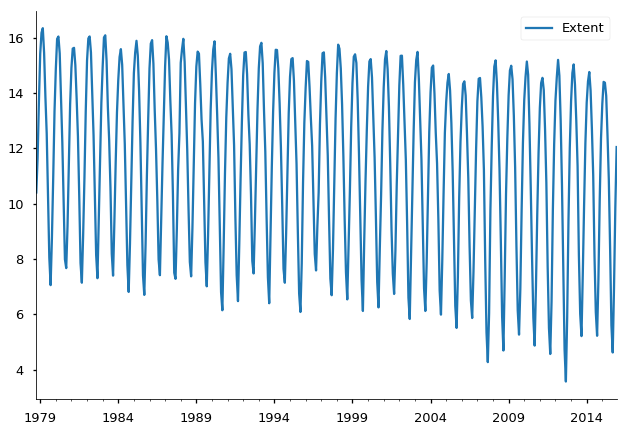

In [103]:
# plot ice extent over time
# seaborn "set_context" sets context parameters, it could be "paper", "talk", "notebook", or "poster"
sns.set_context('talk')
monthly.plot(x=monthly.index, y='Extent')
# remove spines (line boundary) of plots
sns.despine()

One useful tool can be to plot the rolling mean, help you to visualize any trends over time. Additionally, it is smart to plot the standard deviation as a line graph to see if it deviates from a straight line.

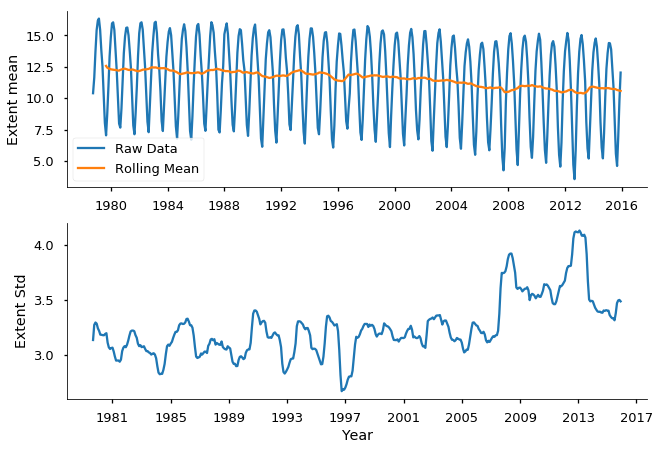

In [106]:
# calculate rolling mean: win = size of window to calculate over
# the window should usually be at least the size of your seasonal period (12 months here)
win = 12

# pandas.DataFrame.rolling provides rolling window calculations
# first 12 numbers are missing 
rollMean = monthly.Extent.rolling(window=win).mean()
rollStd = monthly.Extent.rolling(window=win).std()

# plot the rolling stats
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(monthly.Extent, label='Raw Data')
ax1.plot(rollMean, label='Rolling Mean')
ax1.set_ylabel('Extent mean')
ax1.legend()
ax2.plot(rollStd, label='Rolling Std')
ax2.set_xlabel('Year')
ax2.set_ylabel('Extent Std')
sns.despine()

Based on these plots, it looks like neither the mean nor the standard deviation are stable over time. But it is still only a small variation, so it is still hard to judge whether or not this time series is stationary. 

** We can use further statistical tests to say if the data are stationary.**

<a id='adf'></a>
### Augmented Dickey-Fuller Test

Time Series models are described in terms of **autoregressive (AR) lags**. So an AR(1) model states that the value at Y<sub>t</sub> depends on the value at Y<sub>t-1</sub>. So we can represent the time series as a model:

Y<sub>t</sub> = Alpha + Rho\*Y<sub>t-1</sub> + Error<sub>t</sub>

It turns out, a time series is perfectly stationary when Rho = 0. This makes intuitive sense: The time series will not depend on its previous value when Rho is 0, so it depends entirely on error and is equivalent to a random walk. A time series is perfectly non-stationary if Rho = 1. Alpha is a coeffecient that we want to estimate such that the Error term is minimized, but let's worry about that later.

The Dickey-Fuller Test asks if Rho in an AR(1) model is equal to 0 (H<sub>0</sub>: Rho=1, H<sub>1</sub>: Rho<1)

The augmented Dickey-Fuller Test just expands this to work for AR(n) models

**A p-value < 0.05 indicates that your time series IS STATIONARY. (H<sub>1</sub> is accepted.)**

** Rho = 0, time series does not depend on its previous value, indicates pure stationary nature **

In [110]:
# tsa stands for time series analysis
from statsmodels.tsa.stattools import adfuller

In [111]:
dftest = adfuller(monthly.Extent, autolag='AIC')

# the statsmodels output is ugly and unlabeled, lets use a function to format it nicely
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                  -1.046763
p-value                          0.735829
# of Lags Used                  12.000000
Number of Observations Used    434.000000
Critical Value (5%)             -2.868223
Critical Value (1%)             -3.445508
Critical Value (10%)            -2.570330
dtype: float64


In this output we can see that the p-value is much larger that 0.05, confirming that the data are **NOT** stationary!

<a id='identifying-trends'></a>
# Identifying Trend and Seasonality

Common sources of non-stationarity are **Trend and Seasonality**:

**Trend** is when your mean drifts over time.

**Seasonality** is variations in specific time frames (like ice melting in summer but accumulating in winter).

In addition to removing these components for forecasting purposes, most data scientists will want to identify these components and look at them historically to see if there are possible reasons for changes in them over time. Perhaps the trend in ice melting reverses around the time electric cars are introduced, for example.

<a id='trend-removal'></a>
### Removing Trend to Make a Time Series Stationary

The simplest way to estimate and remove trend is to calculate a rolling mean and subtract it out:

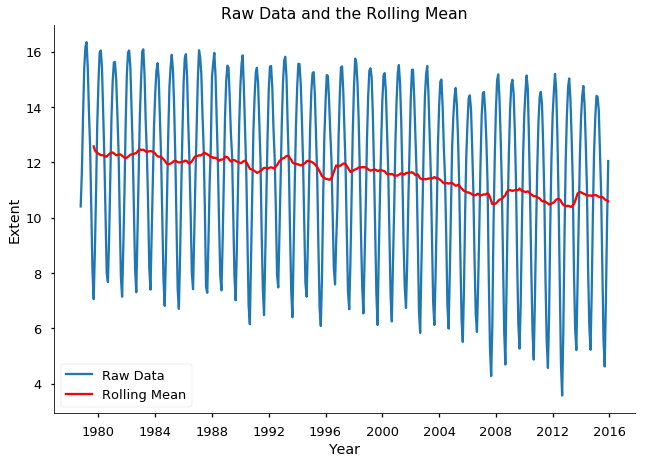

In [112]:
# calculate rolling mean
win = 12
rollMean = monthly.Extent.rolling(window=win, center=False).mean()

# plot
sns.set_context('talk')
plt.plot(monthly.Extent, label='Raw Data')
plt.plot(rollMean, color='red', label='Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Extent')
plt.legend()
plt.title("Raw Data and the Rolling Mean")
sns.despine()

Notice that in the above plot, a few data points are missing from the front of the rolling mean time series. This is because of the window for calculating the moving average. We can remove those NAs and then detrend the time series. 

**This loss of data from the front of the rolling mean time series is a good reason to keep the window as small as possible.**

In [114]:
# subtract mean
demeaned = monthly.Extent - rollMean
demeaned.dropna(inplace=True)

# did this do anything for our stationarity?
demeaned_adf = adfuller(demeaned, autolag='AIC')
adf_output(demeaned_adf)

Test Statistic                -7.377324e+00
p-value                        8.653552e-11
# of Lags Used                 1.700000e+01
Number of Observations Used    4.180000e+02
Critical Value (5%)           -2.868479e+00
Critical Value (1%)           -3.446091e+00
Critical Value (10%)          -2.570466e+00
dtype: float64


# Hooray !

**With the output above, you can see that this simple transformation made the data stationary. **<br> Below, you can see that the moving average is now more stable.

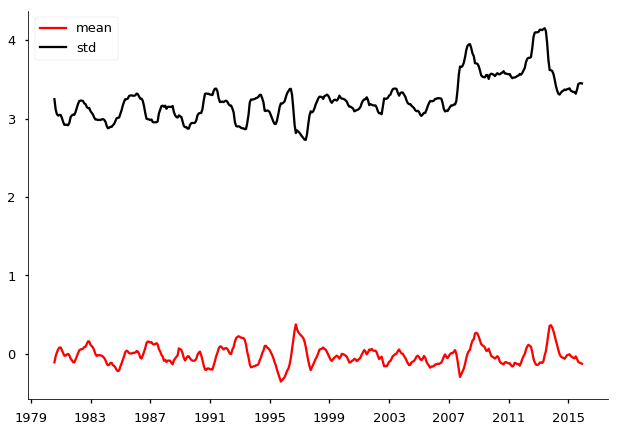

In [115]:
# rolling mean and std
win = 12
roll_demean = demeaned.rolling(window=win, center=False).mean()
roll_demean_std = demeaned.rolling(window=win, center=False).std()

# plot
plt.plot(roll_demean, color='red', label='mean')
plt.plot(roll_demean_std, color='black', label='std')
plt.legend(loc=2)
sns.despine()

**This is also apparent in the lack of decreasing trend in our demeaned time series**

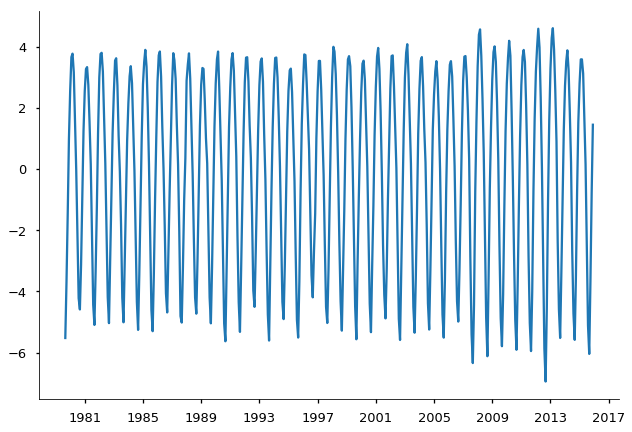

In [116]:
# plot the de-meaned time series
plt.plot(demeaned)
sns.despine()

<a id='differencing'></a>
### Differencing to Detrend

Another common method for removing trend is differencing. In this technique, you just subtract from your time series the time series shifted by t-1. Much like demeaning, this operation leaves you with just the change across time, which  often leads to a stationary series. You can then just model that change and superimpose it back on the trend.

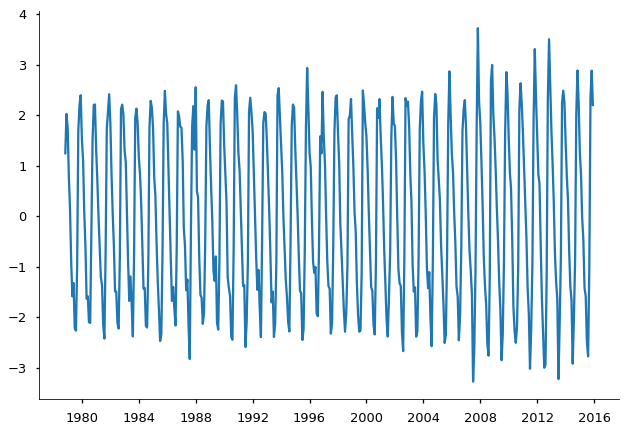

In [117]:
# construct difference curve and plot
# pandas.DataFrame.shift: shifts index by desired number of periods, default period length is 1.
diffed = monthly.Extent - monthly.Extent.shift()
diffed.dropna(inplace=True)
plt.plot(diffed)
sns.despine()

In [118]:
diffed_adf = adfuller(diffed, autolag='AIC')
adf_output(diffed_adf)

Test Statistic                -1.003212e+01
p-value                        1.574993e-17
# of Lags Used                 1.100000e+01
Number of Observations Used    4.340000e+02
Critical Value (5%)           -2.868223e+00
Critical Value (1%)           -3.445508e+00
Critical Value (10%)          -2.570330e+00
dtype: float64


Differencing can also be useful when done multiple times, depending on the time series.

<br>

<a id='decomposition'></a>
### Decomposition - Modeling Trend and Season Separately

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

# In "additive" model, Y[t] = Trend[t] + Seasonal[t] + e[t]
decomp = seasonal_decompose(monthly.Extent, model="additive")

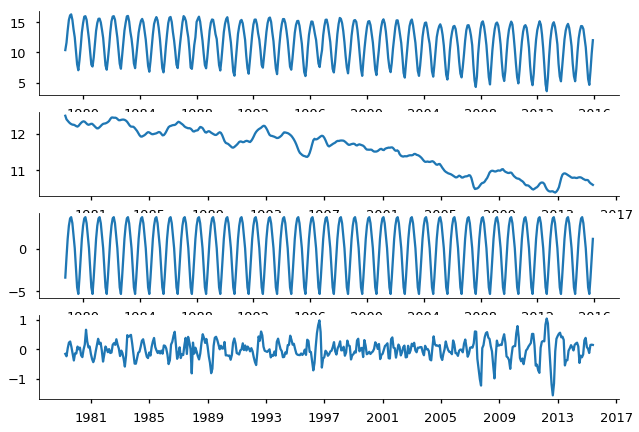

In [120]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
ax1.plot(monthly.Extent)
ax2.plot(decomp.trend)
ax3.plot(decomp.seasonal)
ax4.plot(decomp.resid)
sns.despine()

**The R statistical language has substantially more support for time series analysis than does Python**, so it may be worth exploring STL Decomposition in R if this decomposition is not getting you very far.

Regardless of how you do your decomposition, **the residual component is what you would use to do your modeling**. A major benefit of decomposition is that now you can visualize the trend and seasonal components separately, allowing you to make inferences from those sources of data.

In [121]:
resid = decomp.resid.dropna()
decomp_adf = adfuller(resid, autolag='AIC')
adf_output(decomp_adf)

Test Statistic                -9.645399e+00
p-value                        1.482504e-16
# of Lags Used                 1.800000e+01
Number of Observations Used    4.160000e+02
Critical Value (5%)           -2.868513e+00
Critical Value (1%)           -3.446168e+00
Critical Value (10%)          -2.570484e+00
dtype: float64


<a id='two-series'></a>
## Relating Two Separate Time Series
You might have some other time series and want to see if it is related to changes in your first time series. For example, we might expect that monthly temperatures predict ice extent in Antarctica

In [124]:
# add monthly temperature data to the mix
tmp = pd.read_csv("Antarctic_Temperatures.csv")
# melt: transform the dataframe from a wide format to a long format
av_temp = pd.melt(tmp, id_vars=['Year'], value_vars=['1','2','3','4','5','6','7','8','9','10','11','12'])
av_temp.columns = ['Year', 'Month', 'Temperature']
av_temp['Day'] = 1
av_temp.index = pd.to_datetime(av_temp.loc[:,['Year', 'Month', 'Day']])
av_temp.head()

,Year,Month,Temperature,Day
2016-01-01,2016,1,-32.8,1
2015-01-01,2015,1,-32.1,1
2014-01-01,2014,1,-30.0,1
2013-01-01,2013,1,-32.2,1
2012-01-01,2012,1,-31.6,1


In [125]:
monthly['Temperature'] = av_temp.Temperature
monthly.head()

,Year,Month,Extent,Day,Temperature
1978-10-01,1978,10,10.402667,1,-58.7
1978-11-01,1978,11,11.645133,1,-41.9
1978-12-01,1978,12,13.667063,1,-29.9
1979-01-01,1979,1,15.414000,1,-31.9
1979-02-01,1979,2,16.175286,1,-45.9


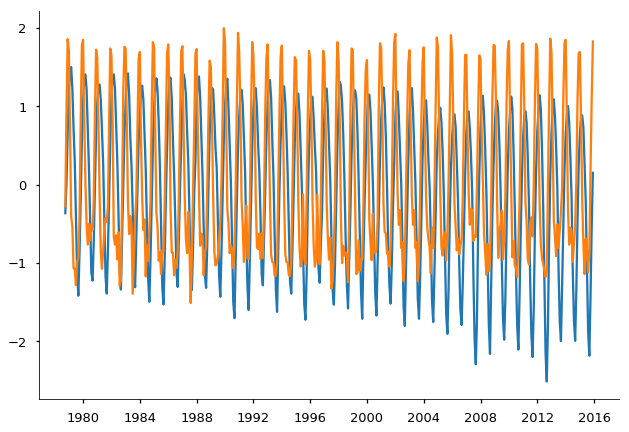

In [126]:
plt.plot((monthly.Extent - np.mean(monthly.Extent)) / np.std(monthly.Extent))
plt.plot((monthly.Temperature - np.mean(monthly.Temperature)) / np.std(monthly.Temperature))
sns.despine()

While hard to see in this graph, it looks like peaks in temperature might precede drops in ice coverage. Lets statistically test this relationship

<a id='granger'></a>
### Granger Causality
Granger Causality is a statistical method for **testing the relationship between two time series**. This can be a great way to supplement an analysis and move beyond simply plotting the decomposed time series.

Which one is more informative?

At it's heart, this method asks whether **values from a second time series** provide more information about the future values of your first time series than just considering **past values of the first time series**:

"X is said to Granger-cause Y if Y can be better predicted using the histories of both X and Y than it can by using the history of Y alone." A good explanation of Granger Causality can be found [here](https://www.r-bloggers.com/chicken-or-the-egg-granger-causality-for-the-masses/) and [here](http://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html) (the first is much simpler, the second is for a real deep dive!).


An important caveat of Granger Causality is that it is very possible to find that X significantly Granger-causes Y, and simultaneously see that Y Granger-causes X. With well selected variables, you can curb this issue to some degree. For example, while maybe possible, it is much more likely that changes in temperature cause ice melting than ice melting causing changes in temperature. It may also be easier to get unidirectional causality in trend components rather than seasonal components.


** First, both time series should be stationary. So we'll do an ADF test on the temperature data and then use the differenced data for monthly ice extent **

In [127]:
temp_adf = adfuller(monthly.Temperature, autolag='AIC')
adf_output(temp_adf)
# The temperature time series data seem stationary, since the p-value is much smaller than 0.05

Test Statistic                  -4.924179
p-value                          0.000031
# of Lags Used                  14.000000
Number of Observations Used    432.000000
Critical Value (5%)             -2.868254
Critical Value (1%)             -3.445578
Critical Value (10%)            -2.570346
dtype: float64


** The Statsmodels Granger Causality package is a bit hard to parse: **
- You should provide it a 2 dimensional structure, where the first column is expected to be caused by the second column
- the maxlag argument lets you run the test with lagged data from your second column
- statsmodels will give you results for a test, incrementing lags, all the way up to your max lags


In [128]:
from statsmodels.tsa.stattools import grangercausalitytests

# create a 2d dataframe to test if ice extent is caused by temperature
granger = pd.DataFrame({'diffed_extent':diffed, 'temperature':av_temp.Temperature})
granger = granger.dropna()
granger

,diffed_extent,temperature
1978-11-01,1.242467,-41.9
1978-12-01,2.021929,-29.9
1979-01-01,1.746937,-31.9
1979-02-01,0.761286,-45.9
1979-03-01,0.166652,-60.5
1979-04-01,-0.895138,-62.2
1979-05-01,-1.589933,-69.4
1979-06-01,-1.326867,-69.4
1979-07-01,-2.218750,-72.3
1979-08-01,-2.270183,-68.3


In [129]:
granger_test = grangercausalitytests(granger, maxlag=12)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=29.0229 , p=0.0000  , df_denom=442, df_num=1
ssr based chi2 test:   chi2=29.2198 , p=0.0000  , df=1
likelihood ratio test: chi2=28.3005 , p=0.0000  , df=1
parameter F test:         F=29.0229 , p=0.0000  , df_denom=442, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=25.4285 , p=0.0000  , df_denom=439, df_num=2
ssr based chi2 test:   chi2=51.4362 , p=0.0000  , df=2
likelihood ratio test: chi2=48.6686 , p=0.0000  , df=2
parameter F test:         F=25.4285 , p=0.0000  , df_denom=439, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=30.6815 , p=0.0000  , df_denom=436, df_num=3
ssr based chi2 test:   chi2=93.5222 , p=0.0000  , df=3
likelihood ratio test: chi2=84.8514 , p=0.0000  , df=3
parameter F test:         F=30.6815 , p=0.0000  , df_denom=436, df_num=3

Granger Causality
('number of lags (no zero)', 4)
ssr based F test:         F=

Here you can see that statsmodels gives a test all the way up to maxlags, increasing the numerator degrees of freedom each time (for the F tests). If you observe a p-value less than .05 for a given test, then the data are consistent with your second column Granger-causing the first column (or a lagged version of the second column Granger-causing the first). Here you see that the data are consistent with granger causality all the way back to a year.

**Granger performs testing all the way up to maxlags (12 months). **

**A p-value < 0.05 means 2nd column Granger-cased the 1st column.**

<a id='summary'></a>
## Take Aways and Next Steps
This notebook is geared toward introducing core concepts of time series analytics. There are a few key take aways:
- Stationarity is an important assumption when decomposing time series data and should be the first thing you assess
    - The Augmented-Dickey Fuller test is useful to test if a time series is stationary
    - You can always transform your data to make it stationary: de-meaning, differencing, and decomposing are common methods
- Examining trend and seasonal components are great ways to understand the behavior of a time series
    - Trend may tell you long term patterns such as decreasing ice extent over a period of decades
        - Trend can be estimated with rolling means or decomposition
    - Seasonality is helpful for understanding short term behaviors
        - You can observe seasonality by removing trend, or through decomposition
- Granger Causality is useful for testing the relationship of two time series
    - Keep in mind the caveat that it is possible to have bi-directional Granger Causality
    
While this notebook was focused on time series analytics, a very common use case of time series data is to **forecast** future behavior of a system. As mentioned before, R has much more developed tools for time series forecasting than python, but it is not impossible to do it in python. Here are some terms to look into for getting started with forecasting techniques:
- ARMA
- ARIMA
- VARIMA
- Holt-Winters
- Recurrent Neural Networks

Some good reading on forecasting time series data can be found [here](https://www.otexts.org/fpp/6/1) and [here](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).

Hopefully now you're ready to dig into your own data!